# Tutorial 11: DeepWalk and node2vec - Implementation details
  

Paper:
* [DeepWalk: Online Learning of Social Representation](https://arxiv.org/pdf/1403.6652.pdf)  
* [node2vec: Scalable Feature Learning for Networks](https://arxiv.org/pdf/1607.00653.pdf)  

Code:

 * [node2vec doc](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html?highlight=node2vec#torch_geometric.nn.models.Node2Vec)
 * [node2vec code](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/node2vec.html)
 * [Example on clustering](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/node2vec.py)

# Setup

In [1]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 423, in run
    _, build_failures = build(
                        ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/wheel_builder.py", line 319, in build
    wheel_file = _build_one(
                 ^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/wheel_builder.py", line 193, in _build_one
    wheel_path = _build_one_i

In [2]:
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.10+${CUDA}.html
!pip install torch_geometric


Looking in links: https://data.pyg.org/whl/torch-2.10+.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-cluster: filename=torch_cluster-1.6.3-cp311-cp311-linux_x86_64.whl size=742657 sha256=2a08be3e777528cb46abbae46ec412e85ff74db507c74e8b0f8a822608f3893e
  Stored in directory: /root/.cache/pip/wheels/ef/de/7d/a4211822af99147b93800e9e204f0be21294e3c0b95b3b861a
Successfully built torch-cluster
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.0 MB/s eta 0:00:00


In [3]:
import torch



# Get the correct Pytorch version

TORCH_VERSION = torch.__version__.split('+')[0]

CUDA_VERSION = "cu118"   # Google Colab uses CUDA 11.8



# Install PyTorch Geometric and required dependencies

!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \-f https://data.pyg.org/whl/torch-{TORCH_VERSION}+{CUDA_VERSION}.html

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.9/950.9 kB 33.0 MB/s eta 0:00:00


In [4]:
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [5]:
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset)
data = dataset[0]

Processing...
Done!


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=128,
                 walk_length=20,                        # lenght of rw
                 context_size=10, walks_per_node=20,
                 num_negative_samples=1,
                 p=200, q=1,                             # bias parameters
                 sparse=True).to(device)

# Random walks

### The data loader

In [7]:
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
for idx, (pos_rw, neg_rw) in enumerate(loader):
    print(idx, pos_rw.shape, neg_rw.shape)

0 torch.Size([28160, 10]) torch.Size([28160, 10])
1 torch.Size([28160, 10]) torch.Size([28160, 10])
2 torch.Size([28160, 10]) torch.Size([28160, 10])
3 torch.Size([28160, 10]) torch.Size([28160, 10])
4 torch.Size([28160, 10]) torch.Size([28160, 10])
5 torch.Size([28160, 10]) torch.Size([28160, 10])
6 torch.Size([28160, 10]) torch.Size([28160, 10])
7 torch.Size([28160, 10]) torch.Size([28160, 10])
8 torch.Size([28160, 10]) torch.Size([28160, 10])
9 torch.Size([28160, 10]) torch.Size([28160, 10])
10 torch.Size([28160, 10]) torch.Size([28160, 10])
11 torch.Size([28160, 10]) torch.Size([28160, 10])
12 torch.Size([28160, 10]) torch.Size([28160, 10])
13 torch.Size([28160, 10]) torch.Size([28160, 10])
14 torch.Size([28160, 10]) torch.Size([28160, 10])
15 torch.Size([28160, 10]) torch.Size([28160, 10])
16 torch.Size([28160, 10]) torch.Size([28160, 10])
17 torch.Size([28160, 10]) torch.Size([28160, 10])
18 torch.Size([28160, 10]) torch.Size([28160, 10])
19 torch.Size([28160, 10]) torch.Size([28

In [9]:
idx, (pos_rw, neg_rw) = next(enumerate(loader))

In [10]:
idx

0

In [11]:
(pos_rw.shape, neg_rw.shape)

(torch.Size([28160, 10]), torch.Size([28160, 10]))

In [12]:
pos_rw

tensor([[1002,  740, 1002,  ..., 2205,   48, 2471],
        [ 242,  279, 2423,  ...,  838,  868, 1526],
        [1899, 2491, 1360,  ..., 1902, 1829, 1902],
        ...,
        [ 142,  525, 2181,  ..., 2074, 1602, 2054],
        [1794,  798, 1795,  ..., 2297, 2298, 2297],
        [  74, 1517,   74,  ..., 1068,  984,  543]])

In [13]:
neg_rw

tensor([[1002, 1400,  331,  ...,  651, 1570, 1599],
        [ 242, 1079, 2072,  ..., 2633,  475, 2056],
        [1899,  795,  664,  ...,  645, 2011,  403],
        ...,
        [ 225, 2158, 2658,  ...,  691, 1451, 1016],
        [1070, 1162, 1553,  ..., 2602,  636, 2021],
        [1188, 2410,  432,  ..., 2374, 1874,  303]])

### Visualization

In [14]:
import networkx as nx
edge_tuples = [tuple(x) for x in data.edge_index.numpy().transpose()]
G = nx.from_edgelist(edge_tuples)
pos = nx.spring_layout(G, center=[0.5, 0.5])
nx.set_node_attributes(G, pos, 'pos')

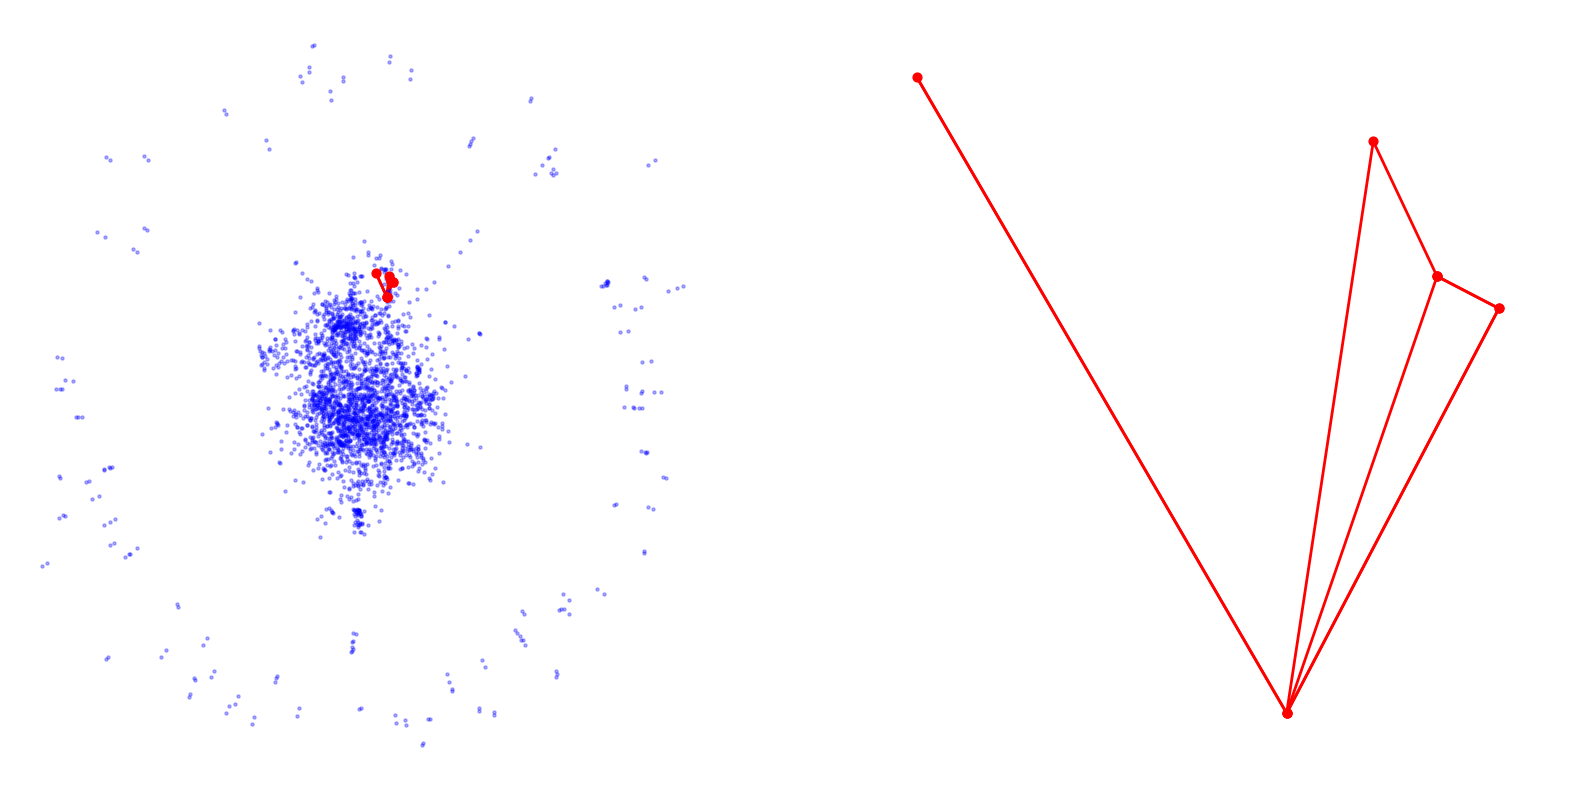

In [15]:
nodelist = next(enumerate(loader))[1][0][0].tolist()
walk = nx.path_graph(len(nodelist))
nx.set_node_attributes(walk, {idx: pos[node_id] for idx, node_id in enumerate(nodelist)}, 'pos')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx_nodes(G,
                       ax=ax,
                       pos=nx.get_node_attributes(G, 'pos'),
                       node_size=5,
                       alpha=0.3,
                       node_color='b')
nx.draw(walk,
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'),
        width=2,
        edge_color='r')
ax = fig.add_subplot(1, 2, 2)
nx.draw(walk,
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'),
        width=2,
        edge_color='r')

# Training

### Model definition

In [ ]:
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

### Training function

In [ ]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

### Test function

In [ ]:
data

In [ ]:
data.y

In [ ]:
data.y.unique()

In [ ]:
@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)
    return acc

### Training

In [ ]:
for epoch in range(1, 201):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

### Visualization

In [ ]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(colors)